<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/playground_colab_mimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.metrics import confusion_matrix, classification_report


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/trainX1.pickle', 'rb') as f:
  X1 = pickle.load(f)
with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/trainX2.pickle', 'rb') as f:
  X2 = pickle.load(f)

trainX = np.concatenate((X1, X2))

with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/testX.pickle', 'rb') as f:
  testX = pickle.load(f)
with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/train_y.pickle', 'rb') as f:
  train_y = pickle.load(f)
with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/test_y.pickle', 'rb') as f:
  test_y = pickle.load(f)



In [0]:
N = trainX.shape[0]
testN = testX.shape[0]

trainX = trainX.reshape((N, 224, 224, 1))
testX = testX.reshape((testN, 224, 224, 1))

In [0]:
# one-hot-encoded vectors, not sure it we need them, the fitting the models with them did not work for me

trainY = np.zeros((N, 3))
testY = np.zeros((testN, 3))

trainY[np.arange(N), train_y] = 1
testY[np.arange(testN), test_y] = 1


In [0]:
model2 = keras.models.Sequential()
model2.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model2.add(layers.MaxPooling2D((4, 4)))
model2.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model2.add(layers.MaxPooling2D((4, 4)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(3))

class_weights = {}
for c in range(3):
  class_weights[c] = 1000/np.sum(train_y==c)
  print(class_weights[c])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


history2 = model2.fit(trainX, train_y, epochs=25, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(testX, test_y))

Epoch 1/25
427/427 [==============================] - 32s 76ms/step - loss: 0.1975 - accuracy: 0.6450 - val_loss: 0.5721 - val_accuracy: 0.8152
Epoch 2/25
427/427 [==============================] - 32s 75ms/step - loss: 0.1638 - accuracy: 0.7303 - val_loss: 0.5990 - val_accuracy: 0.7974
Epoch 3/25
427/427 [==============================] - 32s 75ms/step - loss: 0.1561 - accuracy: 0.7463 - val_loss: 0.5656 - val_accuracy: 0.7907
Epoch 4/25
427/427 [==============================] - 32s 74ms/step - loss: 0.1342 - accuracy: 0.7775 - val_loss: 0.5541 - val_accuracy: 0.8000
Epoch 5/25
427/427 [==============================] - 32s 74ms/step - loss: 0.1221 - accuracy: 0.7911 - val_loss: 0.4897 - val_accuracy: 0.8212
Epoch 6/25
427/427 [==============================] - 32s 75ms/step - loss: 0.1077 - accuracy: 0.8057 - val_loss: 0.4883 - val_accuracy: 0.8139
Epoch 7/25
427/427 [==============================] - 32s 75ms/step - loss: 0.0986 - accuracy: 0.8172 - val_loss: 0.4138 - val_accuracy:

Confusion matrix:
[[814  61  10]
 [ 77 503  14]
 [  6   3  22]]


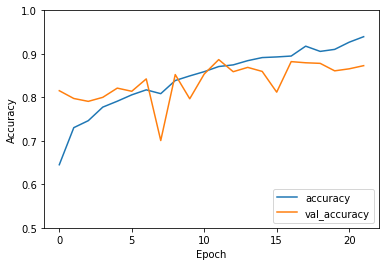

In [0]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model2.predict(testX)
test_y_pred2 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred2, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)


Epoch 1/25
427/427 [==============================] - 33s 76ms/step - loss: 0.6783 - accuracy: 0.7821 - val_loss: 0.4229 - val_accuracy: 0.8377
Epoch 2/25
427/427 [==============================] - 33s 76ms/step - loss: 0.5182 - accuracy: 0.8412 - val_loss: 0.3678 - val_accuracy: 0.8583
Epoch 3/25
427/427 [==============================] - 33s 76ms/step - loss: 0.4461 - accuracy: 0.8565 - val_loss: 0.3802 - val_accuracy: 0.8470
Epoch 4/25
427/427 [==============================] - 33s 76ms/step - loss: 0.3855 - accuracy: 0.8750 - val_loss: 0.3009 - val_accuracy: 0.8967
Epoch 5/25
427/427 [==============================] - 32s 76ms/step - loss: 0.3561 - accuracy: 0.8838 - val_loss: 0.3479 - val_accuracy: 0.8762
Epoch 6/25
427/427 [==============================] - 32s 76ms/step - loss: 0.3237 - accuracy: 0.8935 - val_loss: 0.3293 - val_accuracy: 0.8801
Epoch 7/25
427/427 [==============================] - 33s 77ms/step - loss: 0.2910 - accuracy: 0.9051 - val_loss: 0.4041 - val_accuracy:

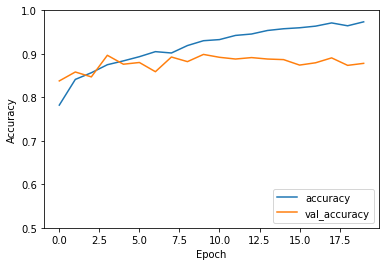

In [0]:
model3 = keras.models.Sequential()
model3.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model3.add(layers.MaxPooling2D((4, 4)))
model3.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model3.add(layers.MaxPooling2D((4, 4)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(3))

class_weights = {}
class_weights[0] = 1
class_weights[1] = 1
class_weights[2] = 4

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history3 = model3.fit(trainX, train_y, epochs=25, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(testX, test_y))  

plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model3.predict(testX)
test_y_pred3 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred3, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)


In [0]:
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', activation='elu', kernel_initializer='he_normal')(X_input)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='elu', kernel_initializer='he_normal')(X)

pepx1 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(X1)
pepx1 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx1)
pepx1 = layers.DepthwiseConv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx1)
pepx1 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx1)
pepx1 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx1)

X = layers.Add()([pepx1, X1])

X2 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='elu', kernel_initializer='he_normal')(X)

pepx2 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(X2)
pepx2 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx2)
pepx2 = layers.DepthwiseConv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx2)
pepx2 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx2)
pepx2 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx2)


X = layers.Add()([pepx2, X2])
X3 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='elu', kernel_initializer='he_normal')(X)

pepx3 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(X3)
pepx3 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx3)
pepx3 = layers.DepthwiseConv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx3)
pepx3 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx3)
pepx3 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx3)

X = layers.Flatten()(pepx3)
X = layers.Dense(128, activation='elu', kernel_initializer='he_normal')(X)
X = layers.Dense(32, activation='elu', kernel_initializer='he_normal')(X)
X = layers.Dense(3, activation='softmax', kernel_initializer='he_normal')(X)

model5 = keras.models.Model(inputs=X_input, outputs=X)
model5.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 112, 112, 64) 3200        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 56, 56, 256)  147712      conv2d_80[0][0]                  
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 56, 56, 16)   4112        conv2d_81[0][0]                  
____________________________________________________________________________________________

In [0]:
class_weights = {}
for c in range(3):
  class_weights[c] = np.sum(train_y==(2-c))/N
  print(class_weights[c])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history5 = model5.fit(trainX, train_y, epochs=5, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(testX, test_y))  

plt.plot(history5.history['accuracy'], label='accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model5.predict(testX)
test_y_pred5 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred5, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)



In [0]:
N = train_y.shape[0]
testN = test_y.shape[0]
for c in range(3):
  print(np.sum(test_y==c)/testN)
print("\n")
for c in range(3):
  print(np.sum(train_y==c)/N)

0.5860927152317881
0.3933774834437086
0.02052980132450331


0.5840175953079179
0.399633431085044
0.016348973607038124


In [0]:
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.MaxPool2D((2,2))(X) 
b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)


X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.MaxPool2D((2,2))(X) 
b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)


X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)


X = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D(2, 2)(X)

X = layers.Flatten()(X)
X = layers.Dense(128, kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Dense(3,kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('softmax')(X)

model6 = keras.models.Model(inputs=X_input, outputs=X, name='model_6')
model6.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [0]:
class_weights = {}
# for c in range(3):
#   class_weights[c] = 1000/np.sum(train_y==c)
#   print(class_weights[c])
class_weights[0] = 1
class_weights[1] = 1
class_weights[2] = 4

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history6 = model6.fit(trainX, train_y, batch_size=8, epochs=25, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(testX, test_y))  



Epoch 1/25
1705/1705 [==============================] - 56s 33ms/step - loss: 1.2713 - accuracy: 0.7567 - val_loss: 0.7875 - val_accuracy: 0.7841
Epoch 2/25
1705/1705 [==============================] - 55s 32ms/step - loss: 1.1539 - accuracy: 0.8185 - val_loss: 0.9528 - val_accuracy: 0.6238
Epoch 3/25
1705/1705 [==============================] - 55s 32ms/step - loss: 1.1089 - accuracy: 0.8375 - val_loss: 0.8717 - val_accuracy: 0.6649
Epoch 4/25
1705/1705 [==============================] - 55s 32ms/step - loss: 1.0777 - accuracy: 0.8526 - val_loss: 0.6714 - val_accuracy: 0.8815
Epoch 5/25
1705/1705 [==============================] - 55s 32ms/step - loss: 1.0618 - accuracy: 0.8576 - val_loss: 0.7314 - val_accuracy: 0.8291
Epoch 6/25
1705/1705 [==============================] - 55s 32ms/step - loss: 1.0443 - accuracy: 0.8658 - val_loss: 0.6608 - val_accuracy: 0.8921
Epoch 7/25
1705/1705 [==============================] - 55s 32ms/step - loss: 1.0252 - accuracy: 0.8746 - val_loss: 0.8358 -

Confusion matrix:
[[801  82   2]
 [ 47 544   3]
 [  3  11  17]]


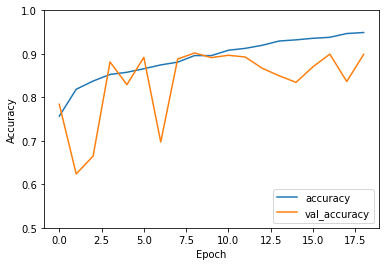

In [0]:
plt.plot(history6.history['accuracy'], label='accuracy')
plt.plot(history6.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model6.predict(testX)
test_y_pred6 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred6, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)

In [11]:
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.MaxPool2D((2,2))(X) 
b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)


X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.MaxPool2D((2,2))(X) 
b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)


X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)

X3 = layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X3 = layers.BatchNormalization()(X3)

b3 = layers.MaxPool2D((2,2))(X) 
b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)
b3 = layers.Activation('relu')(b3)
b3 = layers.Conv2D(1024, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)


X = layers.Add()([X3, b3])
X = layers.Activation('relu')(X)

X = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D(2, 2)(X)

X = layers.Flatten()(X)
X = layers.Dense(128, kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Dense(3,kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('softmax')(X)

model7 = keras.models.Model(inputs=X_input, outputs=X, name='model_7')
model7.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 112, 112, 64) 3200        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 112, 112, 64) 256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 112, 112, 64) 0           batch_normalization_26[0][0]     
____________________________________________________________________________________________

Epoch 1/25
1705/1705 [==============================] - 254s 149ms/step - loss: 1.2699 - accuracy: 0.7707 - val_loss: 0.7149 - val_accuracy: 0.8762
Epoch 2/25
1705/1705 [==============================] - 253s 149ms/step - loss: 1.1438 - accuracy: 0.8304 - val_loss: 0.8083 - val_accuracy: 0.7344
Epoch 3/25
1705/1705 [==============================] - 253s 149ms/step - loss: 1.1089 - accuracy: 0.8397 - val_loss: 0.8306 - val_accuracy: 0.7179
Epoch 4/25
1705/1705 [==============================] - 253s 149ms/step - loss: 1.0733 - accuracy: 0.8567 - val_loss: 0.6723 - val_accuracy: 0.8854
Epoch 5/25
1705/1705 [==============================] - 253s 149ms/step - loss: 1.0607 - accuracy: 0.8611 - val_loss: 0.7383 - val_accuracy: 0.8159
Epoch 6/25
1705/1705 [==============================] - 253s 149ms/step - loss: 1.0523 - accuracy: 0.8648 - val_loss: 0.7773 - val_accuracy: 0.7901
Epoch 7/25
1705/1705 [==============================] - 253s 149ms/step - loss: 1.0355 - accuracy: 0.8740 - val_

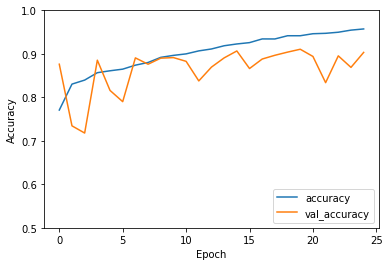

In [12]:
class_weights = {}
# for c in range(3):
#   class_weights[c] = 1000/np.sum(train_y==c)
#   print(class_weights[c])
class_weights[0] = 1
class_weights[1] = 2
class_weights[2] = 8

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history7 = model7.fit(trainX, train_y, batch_size=8, epochs=25, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(testX, test_y))  


plt.plot(history7.history['accuracy'], label='accuracy')
plt.plot(history7.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model7.predict(testX)
test_y_pred7 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred7, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred7, digits=3))

In [6]:
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.MaxPool2D((2,2))(X) 
b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)

X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)


X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.MaxPool2D((2,2))(X) 
b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)


X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)

X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)

X3 = layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X3 = layers.BatchNormalization()(X3)

b3 = layers.MaxPool2D((2,2))(X) 
b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)
b3 = layers.Activation('relu')(b3)
b3 = layers.Conv2D(1024, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)


X = layers.Add()([X3, b3])
X = layers.Activation('relu')(X)

X3 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal')(X)
X3 = layers.BatchNormalization()(X3)

b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)
b3 = layers.Activation('relu')(b3)
b3 = layers.Conv2D(1024, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)

X = layers.Add()([X3, b3])
X = layers.Activation('relu')(X)

X = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D(2, 2)(X)

X = layers.Flatten()(X)
X = layers.Dense(128, kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Dense(3,kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('softmax')(X)

model8 = keras.models.Model(inputs=X_input, outputs=X, name='model_7')
model8.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 112, 112, 64) 3200        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 112, 112, 64) 256         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 112, 112, 64) 0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

Epoch 1/25
1705/1705 [==============================] - 461s 270ms/step - loss: 1.2835 - accuracy: 0.7564 - val_loss: 0.8784 - val_accuracy: 0.6596
Epoch 2/25
1705/1705 [==============================] - 454s 267ms/step - loss: 1.1566 - accuracy: 0.8222 - val_loss: 0.9304 - val_accuracy: 0.6066
Epoch 3/25
1705/1705 [==============================] - 454s 267ms/step - loss: 1.1207 - accuracy: 0.8349 - val_loss: 0.8972 - val_accuracy: 0.6444
Epoch 4/25
1705/1705 [==============================] - 455s 267ms/step - loss: 1.0920 - accuracy: 0.8446 - val_loss: 0.8626 - val_accuracy: 0.6623
Epoch 5/25
1705/1705 [==============================] - 455s 267ms/step - loss: 1.0676 - accuracy: 0.8620 - val_loss: 0.6616 - val_accuracy: 0.8907
Epoch 6/25
1705/1705 [==============================] - 455s 267ms/step - loss: 1.0612 - accuracy: 0.8622 - val_loss: 0.7228 - val_accuracy: 0.8291
Epoch 7/25
1705/1705 [==============================] - 455s 267ms/step - loss: 1.0410 - accuracy: 0.8735 - val_

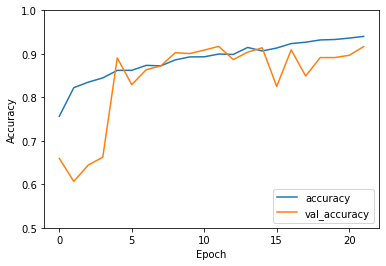

In [7]:
class_weights = {}
# for c in range(3):
#   class_weights[c] = 1000/np.sum(train_y==c)
#   print(class_weights[c])
class_weights[0] = 1
class_weights[1] = 2
class_weights[2] = 8

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

filename = "/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/model8.ckpt"

cp = tf.keras.callbacks.ModelCheckpoint(filepath=filename,  
                                        monitor="val_accuracy",
                                        safe_best_only = True,
                                        verbose=1)


model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history8 = model8.fit(trainX, train_y, batch_size=8, epochs=25, callbacks=[early_stopping, cp],
                    class_weight=class_weights, validation_data=(testX, test_y))  


plt.plot(history8.history['accuracy'], label='accuracy')
plt.plot(history8.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model8.predict(testX)
test_y_pred8 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred8, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred8, digits=3))

In [0]:
filename = "/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/model8.h5"
model8.save(filename)

In [21]:
loaded = keras.models.load_model(filename) # model8.load_weights(os.path.join(filename, saved)
test_y_pred_m = loaded.predict(testX)
test_y_pred8 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred8, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred8, digits=3))

Confusion matrix:
[[839  41   5]
 [ 69 522   3]
 [  6   1  24]]
              precision    recall  f1-score   support

           0      0.918     0.948     0.933       885
           1      0.926     0.879     0.902       594
           2      0.750     0.774     0.762        31

    accuracy                          0.917      1510
   macro avg      0.864     0.867     0.865      1510
weighted avg      0.917     0.917     0.917      1510



In [15]:
loaded_model8


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb81ba6c5c0>